In [1]:
# EDA images COVID radiography dataset
# Imports
from pathlib import Path  # gestion de chemins multiplateforme
import os  # opérations système (peut être utile pour d'autres scripts)
import sys  # gestion du path Python (non utilisé directement ici)
import numpy as np  # calcul numérique
import pandas as pd  # tables de données
from PIL import Image, ImageOps  # chargement et transformation d'images
import matplotlib.pyplot as plt  # traçage
import seaborn as sns  # graphiques statistiques
from tqdm import tqdm  # barres de progression
import hashlib  # hachage de fichiers

# Matplotlib style
plt.style.use('seaborn-v0_8')  # style cohérent
sns.set_context('talk')  # taille des polices lisible en notebook

# Paths
PROJECT_ROOT = Path(os.getcwd())  # racine du projet
DATASET_ROOT = PROJECT_ROOT / 'data'  # racine du dataset
assert DATASET_ROOT.exists(), f"Dataset not found at {DATASET_ROOT}"  # stoppe si dossier absent

CLASSES = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']  # classes du dataset
SUBFOLDERS = ['images', 'masks']  # sous-dossiers attendus

print('Dataset root:', DATASET_ROOT)  # affichage d'information
for cls in CLASSES:  # boucle sur les classes
    for sub in SUBFOLDERS:  # boucle sur images/masks
        p = DATASET_ROOT / cls / sub  # compose le chemin
        print(f"{cls}/{sub} ->", 'OK, no missing' if p.exists() else 'MISSING')  # statut


Dataset root: d:\DST-MLE\projet_covid_19\projet\data
COVID/images -> OK, no missing
COVID/masks -> OK, no missing
Lung_Opacity/images -> OK, no missing
Lung_Opacity/masks -> OK, no missing
Normal/images -> OK, no missing
Normal/masks -> OK, no missing
Viral Pneumonia/images -> OK, no missing
Viral Pneumonia/masks -> OK, no missing


In [2]:
def list_files_by_extension(path: Path, extensions={'.png', '.jpg', '.jpeg'}):
    # retourne tous les fichiers dont l'extension correspond (recherche récursive)
    return [p for p in path.rglob('*') if p.suffix.lower() in extensions]

rows = []  # on accumule une ligne par (classe, subset)
img_rows = []
for cls in CLASSES:  # boucle classes
    for sub in SUBFOLDERS:  # boucle images/masks
        base = DATASET_ROOT / cls / sub  # répertoire cible
        files = list_files_by_extension(base, {'.png'})  # dataset en PNG
        rows.append({'class': cls, 'subset': sub, 'count': len(files)})  # ajoute le comptage


             class  subset  count
0            COVID  images   3616
1            COVID   masks   3616
2     Lung_Opacity  images   6012
3     Lung_Opacity   masks   6012
4           Normal  images  10192
5           Normal   masks  10192
6  Viral Pneumonia  images   1345
7  Viral Pneumonia   masks   1345


subset           images  masks
class                         
COVID              3616   3616
Lung_Opacity       6012   6012
Normal            10192  10192
Viral Pneumonia    1345   1345

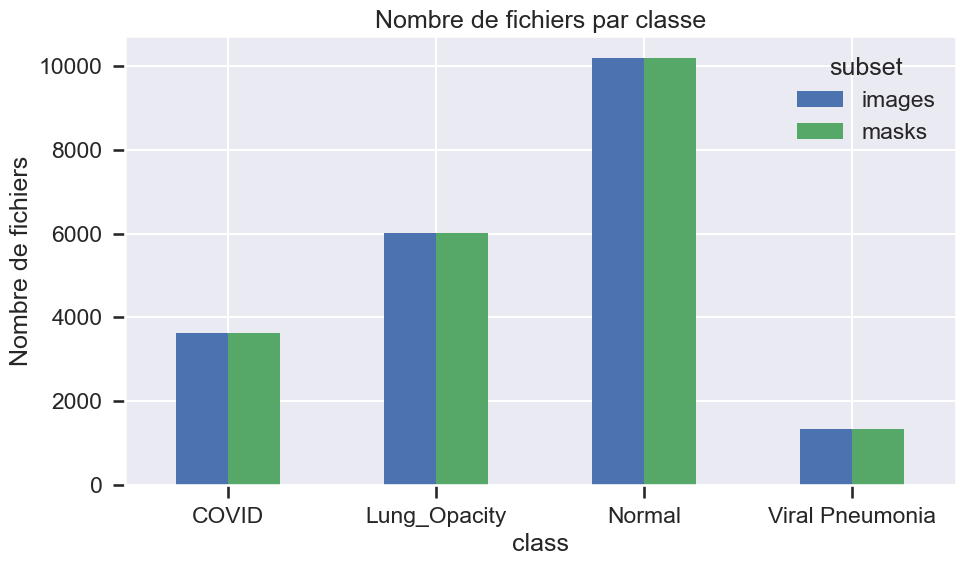

In [3]:
counts_df = pd.DataFrame(rows)  # tableau des comptages
print(counts_df)  # aperçu brut

# Pivot pour lisibilité (classes en lignes, subsets en colonnes)
pivot_counts = counts_df.pivot(index='class', columns='subset', values='count').fillna(0).astype(int)
display(pivot_counts)

# Barplot des comptages images/masks par classe
ax = pivot_counts[['images','masks']].plot(kind='bar', figsize=(10,6))
ax.set_title('Nombre de fichiers par classe')
ax.set_ylabel('Nombre de fichiers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


             class  subset  count
0            COVID  images   3616
2     Lung_Opacity  images   6012
4           Normal  images  10192
6  Viral Pneumonia  images   1345
21165


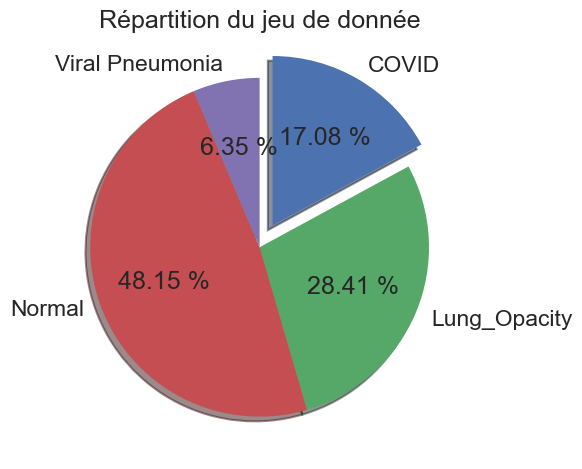

In [4]:
counts_image = counts_df[counts_df["subset"] == "images"]  # tableau des comptages
print(counts_image)  # aperçu brut
total = counts_image["count"].sum()
print(total)

# On calcule le décalage du secteur "Python", via une liste en intention.
explode = [0.15 if c == "COVID" else 0 for c in counts_image["class"]]

# Création du graphique circulaire
plt.pie(counts_image["count"], 
        labels=counts_image["class"],
        explode=explode,               # Les décalages pour faire ressortir Python 
        autopct='%.2f %%',             # Le format utilisé pour l'affichage des valeurs (2 chiffres après la vigule)
        shadow=True,                   # On veut une ombre portée
        startangle=90,                 # L'angle de démarrage pour afficher la première valeur
        counterclock=False)            # Dans quel sens on affiche les données

# Ajout de titre
plt.title("Répartition du jeu de donnée")

# Affichage de la figure (surtout utile, si MPL est utilisé de manière standalone)
plt.show()

In [5]:
#On constate que la proportion de positif (COVID) est assez faible par rapport au nombre de cas négatifs
#A analyser si il faut reduire le nombre de cas négatif pour limiter les biais

In [5]:
# Statistiques de dimensions, modes et tailles de fichier (échantillonné)
from random import sample  # échantillonnage pour limiter le coût

def gather_image_stats(paths, max_samples=3000):
    # échantillonne au plus max_samples chemins
    if len(paths) > max_samples:
        paths = sample(paths, max_samples)
    records = []  # lignes de statistiques par image
    for p in tqdm(paths, desc='Scanning images'):
        try:
            with Image.open(p) as im:  # ouvre l'image
                width, height = im.size  # récupère largeur/hauteur
                mode = im.mode  # mode (L, RGB, ...)
        except Exception as e:
            width = height = None  # si erreur, marque comme None
            mode = 'CORRUPT'  # tag de corruption
        try:
            file_size = p.stat().st_size  # taille sur disque (octets)
        except Exception:
            file_size = None
        records.append({'path': str(p), 'width': width, 'height': height, 'mode': mode, 'bytes': file_size})
    return pd.DataFrame(records)  # retourne un DataFrame



Scanning images: 100%|██████████| 21165/21165 [02:04<00:00, 169.36it/s]


path  width  height mode  \
0  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...    299     299    L   
1  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...    299     299    L   
2  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...    299     299    L   
3  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...    299     299    L   
4  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...    299     299    L   

   bytes  megabytes  
0  28209   0.026902  
1  36458   0.034769  
2  32856   0.031334  
3  33312   0.031769  
4  33337   0.031793

Total analysé: 21165


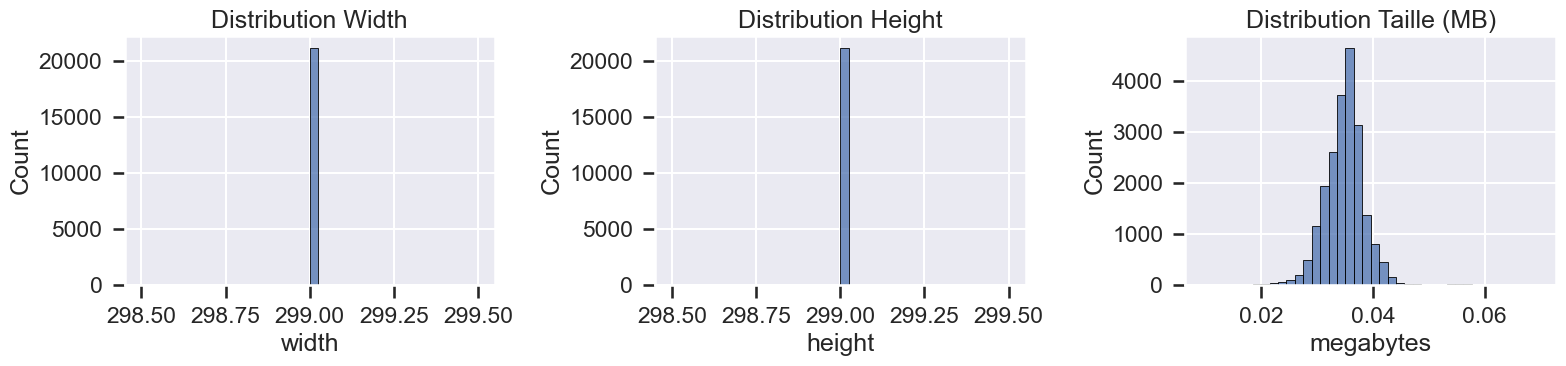

Modes image:
 mode
L      21025
RGB      140
Name: count, dtype: int64


In [6]:
all_image_paths = []  # tous les chemins d'images (toutes classes)
for cls in CLASSES:
    all_image_paths += list_files_by_extension(DATASET_ROOT / cls / 'images', {'.png'})

stats_df = gather_image_stats(all_image_paths,max_samples=len(all_image_paths))# max_samples=40000)  # collecte stats
stats_df['megabytes'] = stats_df['bytes'].astype('float') / (1024*1024)  # conversion taille en MB

display(stats_df.head())  # aperçu
print('Total analysé:', len(stats_df))  # nombre d'images analysées

fig, axes = plt.subplots(1,3, figsize=(16,4))  # 3 histogrammes
sns.histplot(stats_df['width'].dropna(), bins=40, ax=axes[0])  # largeur
axes[0].set_title('Distribution Width')
sns.histplot(stats_df['height'].dropna(), bins=40, ax=axes[1])  # hauteur
axes[1].set_title('Distribution Height')
sns.histplot(stats_df['megabytes'].dropna(), bins=40, ax=axes[2])  # taille fichier
axes[2].set_title('Distribution Taille (MB)')
plt.tight_layout()
plt.show()

mode_counts = stats_df['mode'].value_counts(dropna=False)  # comptage des modes
print('Modes image:\n', mode_counts)  # L attendu majoritaire


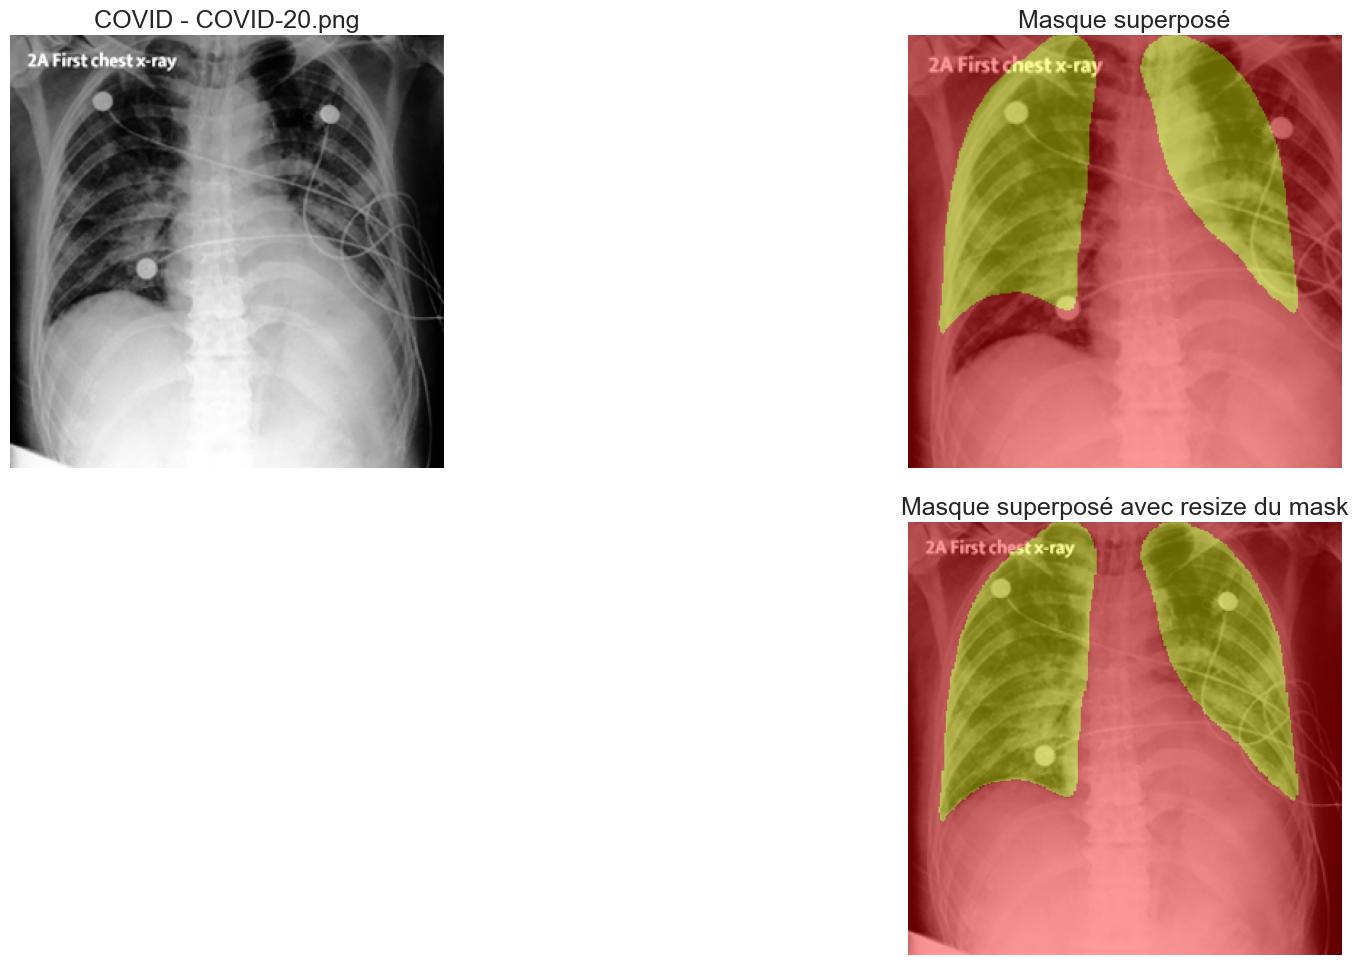

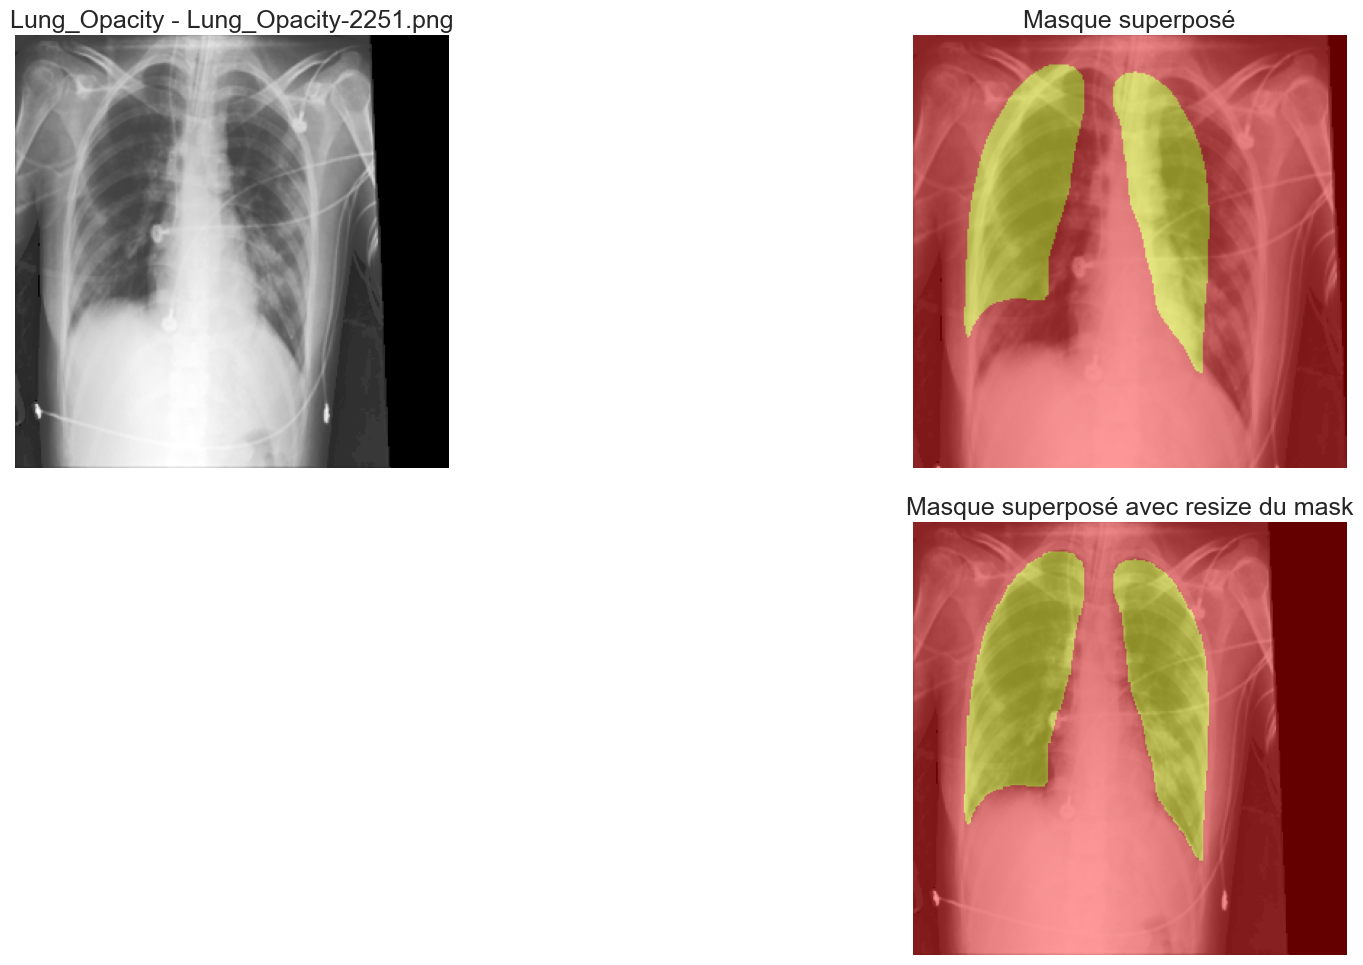

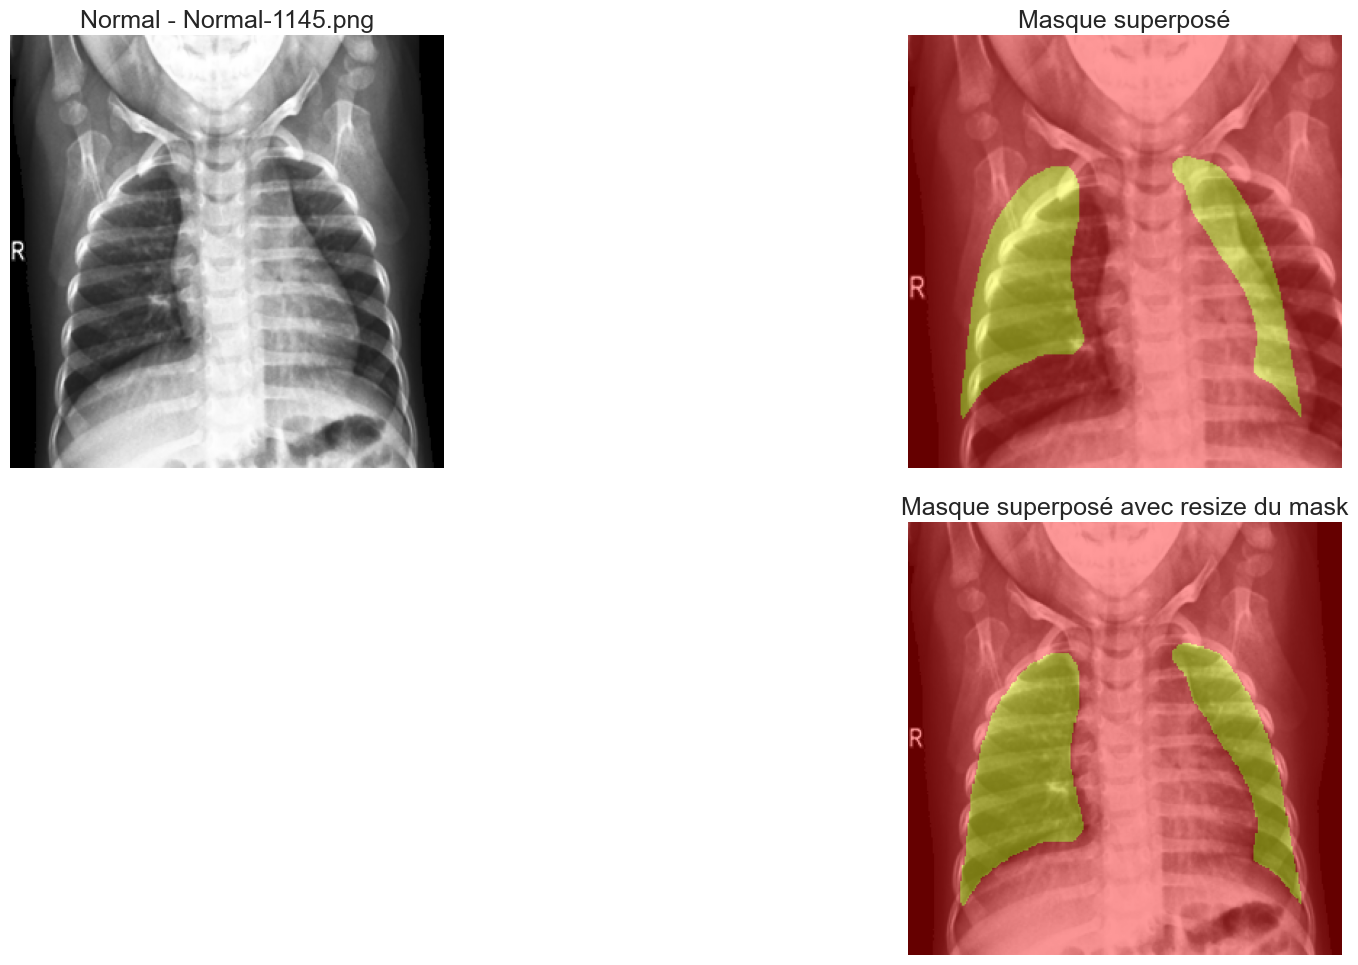

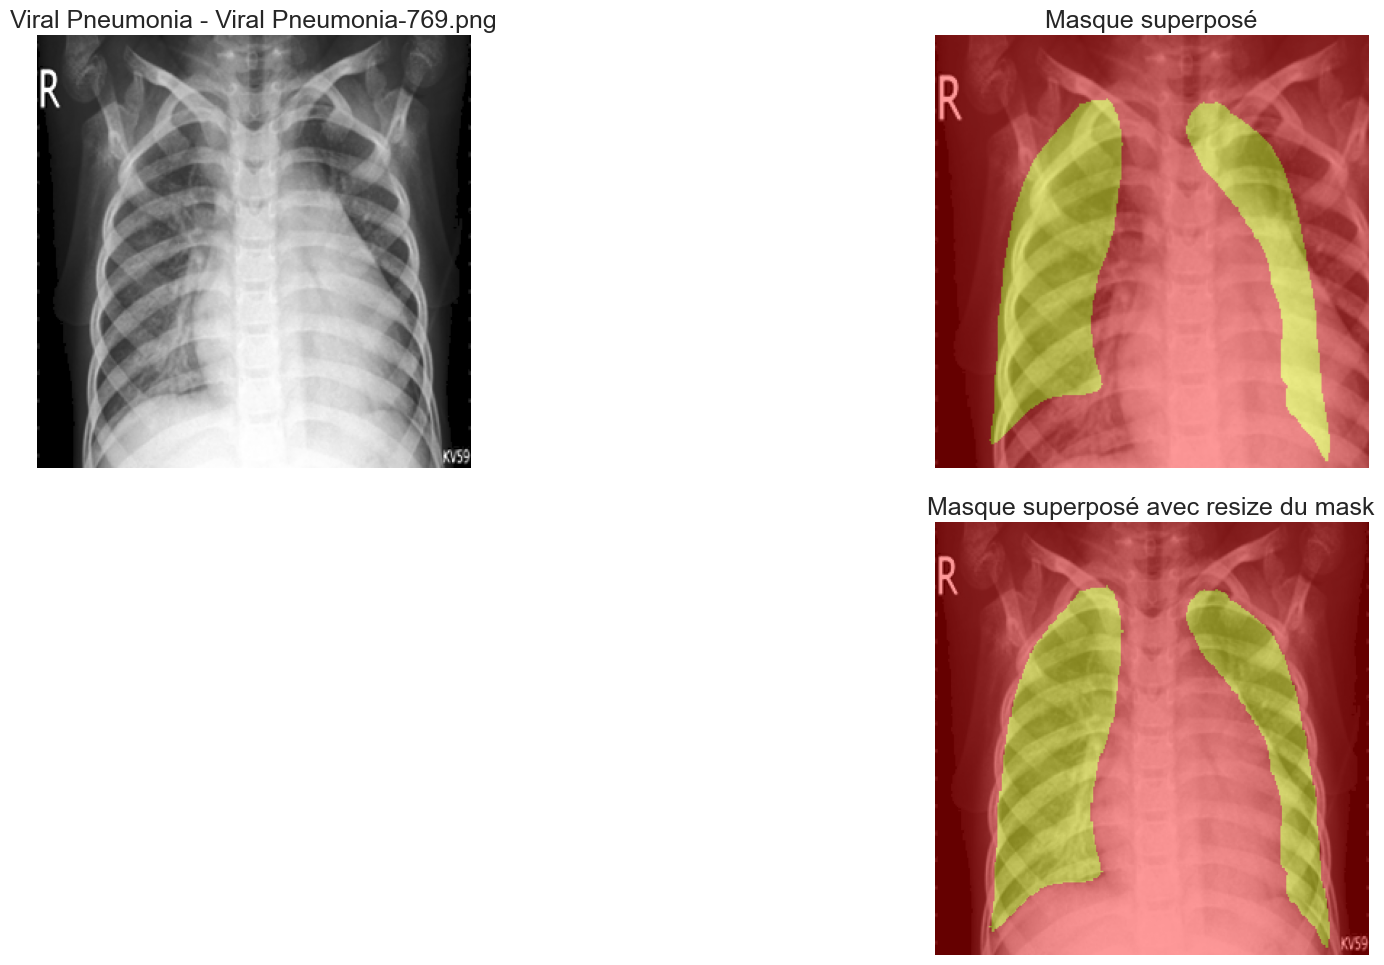

In [7]:
# Visualisation: exemples aléatoires avec superposition de masque (si disponible)
from random import randint  # choix aléatoire d'indice

def show_sample_with_mask(cls: str, idx: int = None):
    img_dir = DATASET_ROOT / cls / 'images'  # dossier images de la classe
    mask_dir = DATASET_ROOT / cls / 'masks'  # dossier masques de la classe
    imgs = sorted(list_files_by_extension(img_dir, {'.png'}))  # liste d'images
    if not imgs:
        print(f'Aucune image pour {cls}')  # garde-fou
        return
    if idx is None:
        idx = randint(0, len(imgs)-1)  # tire un index aléatoire
    img_path = imgs[idx]  # chemin de l'image choisie
    # Construire chemin du masque par convention de nom identique
    mask_candidate = mask_dir / img_path.name

    with Image.open(img_path) as im:
        im_disp = ImageOps.equalize(im.convert('L'))  # contraste equalize sur niveau de gris
    mask = None
    if mask_candidate.exists():
        try:
            with Image.open(mask_candidate) as m:
                mask = m.convert('L')  # masque en niveaux de gris
        except Exception:
            mask = None  # si masque illisible

    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.imshow(im_disp, cmap='gray')  # image brute
    plt.title(f'{cls} - {img_path.name}')
    plt.axis('off')

    plt.subplot(2,2,2)
    if mask is not None:
        plt.imshow(im_disp, cmap='gray')  # fond: image
        plt.imshow(np.array(mask) > 0, cmap='autumn', alpha=0.4)  # overlay: masque binaire
        plt.title('Masque superposé')
    else:
        plt.imshow(im_disp, cmap='gray')
        plt.title('Masque indisponible')
    plt.axis('off')

    plt.subplot(2,2,4)
    if mask is not None:
        plt.imshow(im_disp, cmap='gray')  # fond: image
        plt.imshow(np.array(mask.resize(size=[im_disp.width,im_disp.height], resample=Image.NEAREST)) > 0, cmap='autumn', alpha=0.4)  # overlay: masque binaire
        plt.title('Masque superposé avec resize du mask')
    else:
        plt.imshow(im_disp, cmap='gray')
        plt.title('Masque indisponible')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for c in CLASSES:
    show_sample_with_mask(c)  # affiche un exemple par classe


In [8]:
# Détection de fichiers corrompus (images uniquement)
corrupt_paths = []  # chemins d'images jugées corrompues
for cls in CLASSES:  # pour chaque classe
    img_dir = DATASET_ROOT / cls / 'images'  # dossier images
    for p in tqdm(list_files_by_extension(img_dir, {'.png'}), desc=f'Checking {cls}'):
        try:
            with Image.open(p) as im:
                im.verify()  # vérifie l'en-tête/structure sans décoder complètement
        except Exception:
            corrupt_paths.append(str(p))  # enregistre le chemin si échec

print(f'Fichiers corrompus trouvés: {len(corrupt_paths)}')  # bilan
if corrupt_paths:
    display(pd.DataFrame({'path': corrupt_paths}).head(20))  # aperçu des premiers


Checking Viral Pneumonia: 100%|██████████| 1345/1345 [00:06<00:00, 196.63it/s]

Fichiers corrompus trouvés: 0


In [9]:
# Détection de doublons par hash (échantillonné pour performance)


def file_hash(path: Path, algo='md5', chunk_size=1<<20):
    h = hashlib.new(algo)  # initialise le hash
    with open(path, 'rb') as f:  # lecture binaire
        while True:
            chunk = f.read(chunk_size)  # lit par blocs
            if not chunk:
                break
            h.update(chunk)  # met à jour le hash
    return h.hexdigest()  # rend l'empreinte hexadécimale

In [10]:
# Détection de doublons par hash (échantillonné pour performance)


sample_per_class = 3000  # bornage pour performance
hash_to_paths = {}  # map hash -> liste de chemins
for cls in CLASSES:  # parcours des classes
    img_paths = list_files_by_extension(DATASET_ROOT / cls / 'images', {'.png'})
    if len(img_paths) > sample_per_class:
        img_paths = sample(img_paths, sample_per_class)  # échantillonnage
    for p in tqdm(img_paths, desc=f'Hashing {cls}'):  # CORRECTION: tqdm() pas tqdm[Path]
        try:
            h = file_hash(p)  # calcule le hash du fichier
        except Exception:
            continue  # ignore erreurs de lecture
        hash_to_paths.setdefault(h, []).append(str(p))  # indexe le chemin

# groupes ayant plus d'un fichier pour un même hash => doublons
duplicates = {h:paths for h,paths in hash_to_paths.items() if len(paths) > 1}
print('Groupes de doublons:', len(duplicates))  # bilan
if duplicates:
    dup_rows = []
    for h, paths in list(duplicates.items())[:10]:  # aperçu limité
        for path in paths:
            dup_rows.append({'hash': h, 'path': path})
            print(path)
    display(pd.DataFrame(dup_rows))  # affiche quelques groupes


Hashing Viral Pneumonia: 100%|██████████| 1345/1345 [00:00<00:00, 1703.21it/s]

Groupes de doublons: 30
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3207.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3208.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-2716.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-2719.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-2717.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-2718.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3299.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3298.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3222.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3223.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3375.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3374.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-3376.png
d:\DST-MLE\projet_covid_19\projet\data\COVID\images\COVID-49.png
d:\DST-MLE\projet_covid_19\projet\data\C

hash  \
0   91fc14a1600056eeac4a16fe41f4e010   
1   91fc14a1600056eeac4a16fe41f4e010   
2   e27ad0c30ae29e488fa6e57ff63a4a1e   
3   e27ad0c30ae29e488fa6e57ff63a4a1e   
4   e27ad0c30ae29e488fa6e57ff63a4a1e   
5   e27ad0c30ae29e488fa6e57ff63a4a1e   
6   13e38943c57770d1fe413482917b709c   
7   13e38943c57770d1fe413482917b709c   
8   97f0927dc25c65b007df3650e50b919d   
9   97f0927dc25c65b007df3650e50b919d   
10  c5438ddcb2ef4d16bd0dae1b8e927b06   
11  c5438ddcb2ef4d16bd0dae1b8e927b06   
12  c5438ddcb2ef4d16bd0dae1b8e927b06   
13  e0e0a347b19729c214fd71221f8401ab   
14  e0e0a347b19729c214fd71221f8401ab   
15  8e7368933d400defbe24f3481ab80b44   
16  8e7368933d400defbe24f3481ab80b44   
17  958760da197ae6522df0afac5c3a1d08   
18  958760da197ae6522df0afac5c3a1d08   
19  fd4fa24f5f5677dd8c886c5171cc171e   
20  fd4fa24f5f5677dd8c886c5171cc171e   
21  6927bed5f4e8c43b3df6e4d36e31e01f   
22  6927bed5f4e8c43b3df6e4d36e31e01f   

                                                 path  
0   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
1   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
2   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
3   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
4   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
5   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
6   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
7   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
8   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
9   d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
10  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
11  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
12  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
13  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
14  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
15  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
16  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
17  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
18  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
19  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
20  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
21  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...  
22  d:\DST-MLE\projet_covid_19\projet\data\COVID\i...

In [12]:
from random import sample  # échantillonnage pour limiter le coût
# Tailles d'images par classe: distributions (boxplot/violin)
size_rows = []  # collecte des mesures par image
for cls in CLASSES:
    img_paths = list_files_by_extension(DATASET_ROOT / cls / 'images', {'.png'})  # images de la classe
    # échantillonner pour performance, garder au moins quelques images si dispo
    if len(img_paths) > 3000:
        img_paths = sample(img_paths, 3000)
    for p in tqdm(img_paths, desc=f'Sizes {cls}'):
        try:
            with Image.open(p) as im:
                w, h = im.size  # largeur/hauteur
        except Exception:
            continue  # ignore si image illisible
        if not w or not h or w <= 0 or h <= 0:
            continue  # ignore dimensions invalides
        size_rows.append({'class': cls, 'width': w, 'height': h, 'area': w*h, 'aspect': w/(h if h else 1)})

sizes_df = pd.DataFrame(size_rows)  # dataframe des tailles


Sizes Viral Pneumonia: 100%|██████████| 1345/1345 [00:00<00:00, 7293.46it/s]


In [13]:
# classes effectivement présentes dans sizes_df (pour l'ordre et la légende)
present_classes = [c for c in CLASSES if c in set(sizes_df['class'])]
display(present_classes)
display(sizes_df.head())  # aperçu

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

class  width  height   area  aspect
0  COVID    299     299  89401     1.0
1  COVID    299     299  89401     1.0
2  COVID    299     299  89401     1.0
3  COVID    299     299  89401     1.0
4  COVID    299     299  89401     1.0

In [14]:
data = []
for c in CLASSES:
    img_folder = DATASET_ROOT / c / "images"
    for file in os.listdir(img_folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            data.append([f"{c}/images/{file}", c])

# Tạo DataFrame
data = pd.DataFrame(data, columns=["image_file", "corona_result"])

In [15]:
data

image_file    corona_result
0                            COVID/images/COVID-1.png            COVID
1                           COVID/images/COVID-10.png            COVID
2                          COVID/images/COVID-100.png            COVID
3                         COVID/images/COVID-1000.png            COVID
4                         COVID/images/COVID-1001.png            COVID
...                                               ...              ...
21160  Viral Pneumonia/images/Viral Pneumonia-995.png  Viral Pneumonia
21161  Viral Pneumonia/images/Viral Pneumonia-996.png  Viral Pneumonia
21162  Viral Pneumonia/images/Viral Pneumonia-997.png  Viral Pneumonia
21163  Viral Pneumonia/images/Viral Pneumonia-998.png  Viral Pneumonia
21164  Viral Pneumonia/images/Viral Pneumonia-999.png  Viral Pneumonia

[21165 rows x 2 columns]

In [16]:
data["path"] = data["image_file"].apply(lambda x: os.path.join(DATASET_ROOT, x))

In [17]:
data["diag"] = data["corona_result"].copy()
data["corona_result"] = data["corona_result"].map({
    "Normal": "Negative",
    "COVID": "Positive",
    "Lung_Opacity": "Negative", #negatif?
    "Viral Pneumonia": "Negative" #negatif?
})


In [18]:
data["corona_result"].value_counts()

corona_result
Negative    17549
Positive     3616
Name: count, dtype: int64

In [19]:
data.head()

image_file corona_result  \
0     COVID/images/COVID-1.png      Positive   
1    COVID/images/COVID-10.png      Positive   
2   COVID/images/COVID-100.png      Positive   
3  COVID/images/COVID-1000.png      Positive   
4  COVID/images/COVID-1001.png      Positive   

                                                path   diag  
0  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID  
1  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID  
2  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID  
3  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID  
4  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID

In [20]:
import pandas as pd
import plotly.express as px

df = data["corona_result"].value_counts().reset_index()
df.columns = ["corona_result", "Count"]
df = df.sort_values(by='Count', ascending=False)

fig = px.bar(
    df,
    x='corona_result',
    y='Count',
    color='corona_result',
    text_auto=True,
    width=700,
    template='plotly_dark',
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.show()

In [21]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

image_file corona_result  \
0     COVID/images/COVID-1.png      Positive   
1    COVID/images/COVID-10.png      Positive   
2   COVID/images/COVID-100.png      Positive   
3  COVID/images/COVID-1000.png      Positive   
4  COVID/images/COVID-1001.png      Positive   

                                                path   diag  \
0  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID   
1  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID   
2  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID   
3  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID   
4  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  COVID   

                                               image  
0  [[15, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
1  [[129, 125, 123, 121, 119, 117, 114, 104, 104,...  
2  [[11, 0, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0...  
3  [[42, 39, 38, 42, 38, 35, 31, 26, 24, 24, 24, ...  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0,...

In [22]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []
samples = 1000

for i in range(0, len(data)):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_std'] = imageEDA['stedev'].mean() - imageEDA['stedev']
imageEDA['subt_max'] = imageEDA['max'].mean() - imageEDA['max']
imageEDA['subt_min'] = imageEDA['min'].mean() - imageEDA['min']

imageEDA.head(1)


image corona_result  \
0  [[15, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...      Positive   

                                                path        mean     stedev  \
0  d:\DST-MLE\projet_covid_19\projet\data\COVID/i...  145.912889  51.656605   

   max  min  subt_mean  subt_std   subt_max  subt_min  
0  214    0 -15.981274  6.935212  17.413796  2.119112

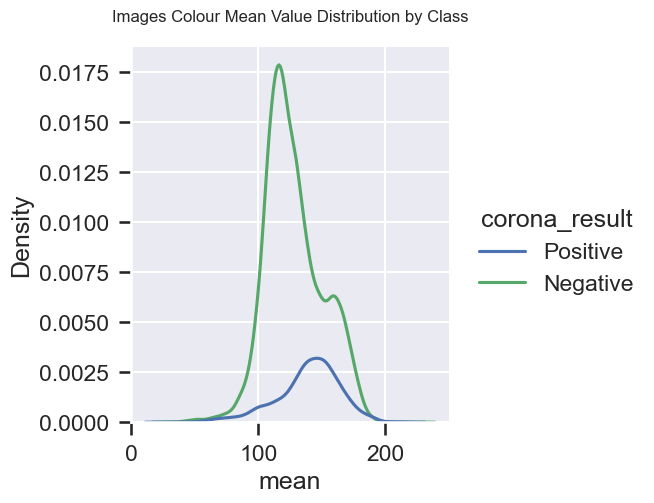

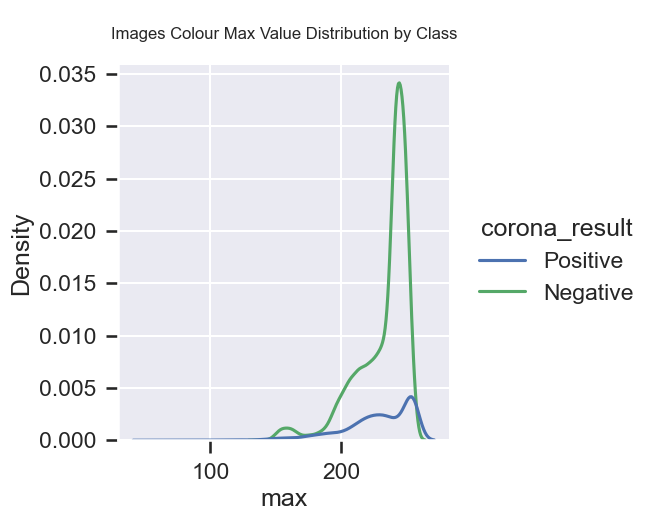

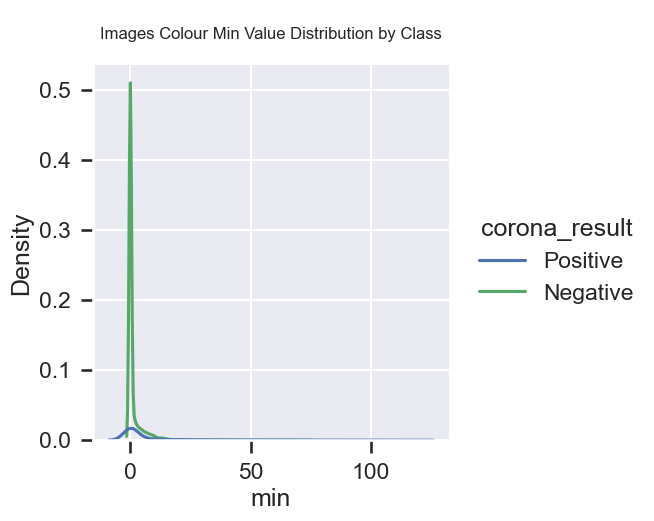

In [23]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

Analyse du graphique Mean vs Density 
Les images Covid négatives (non infectées) ont une valeur moyenne des pixels concentrée autour de 120-140.Les images Covid positives ont une distribution plus large, oscillant entre 100 et 160, et ont tendance à dévier vers la droite (valeur légèrement plus élevée).
Remarque : les radiographies des patients Covid positifs ont généralement une luminosité plus inégale(ou dispérsée) en raison des lésions pulmonaires qui provoquent des zones opaques, modifiant ainsi la valeur moyenne des pixels


Analyse du graphique Max vs Density (valeur maximale des pixels)Les images négatives ont une valeur maximale de pixel (légèrement)élevée, concentrée autour de 240-255, ce qui indique que la partie la plus claire de l'image conserve un contraste élevé. Les images positives ont une distribution plus large, certaines images ayant une valeur maximale plus faible (~200-250).
Remarque : les images des patients Covid peuvent présenter une réduction du contraste dans les zones claires en raison des lésions pulmonaires

Analyse du graphique Min vs Density (valeur minimale des pixels)Les images négatives ont une valeur minimale concentrée autour de 0, ce qui indique que l'arrière-plan de l'image est nettement noir.Les images positives ont également une valeur minimale très faible, mais leur distribution est un légèrement plus large (~0-10).
Remarque : les images des patients Covid peuvent contenir plus de bruit dû aux instrument par exemple 

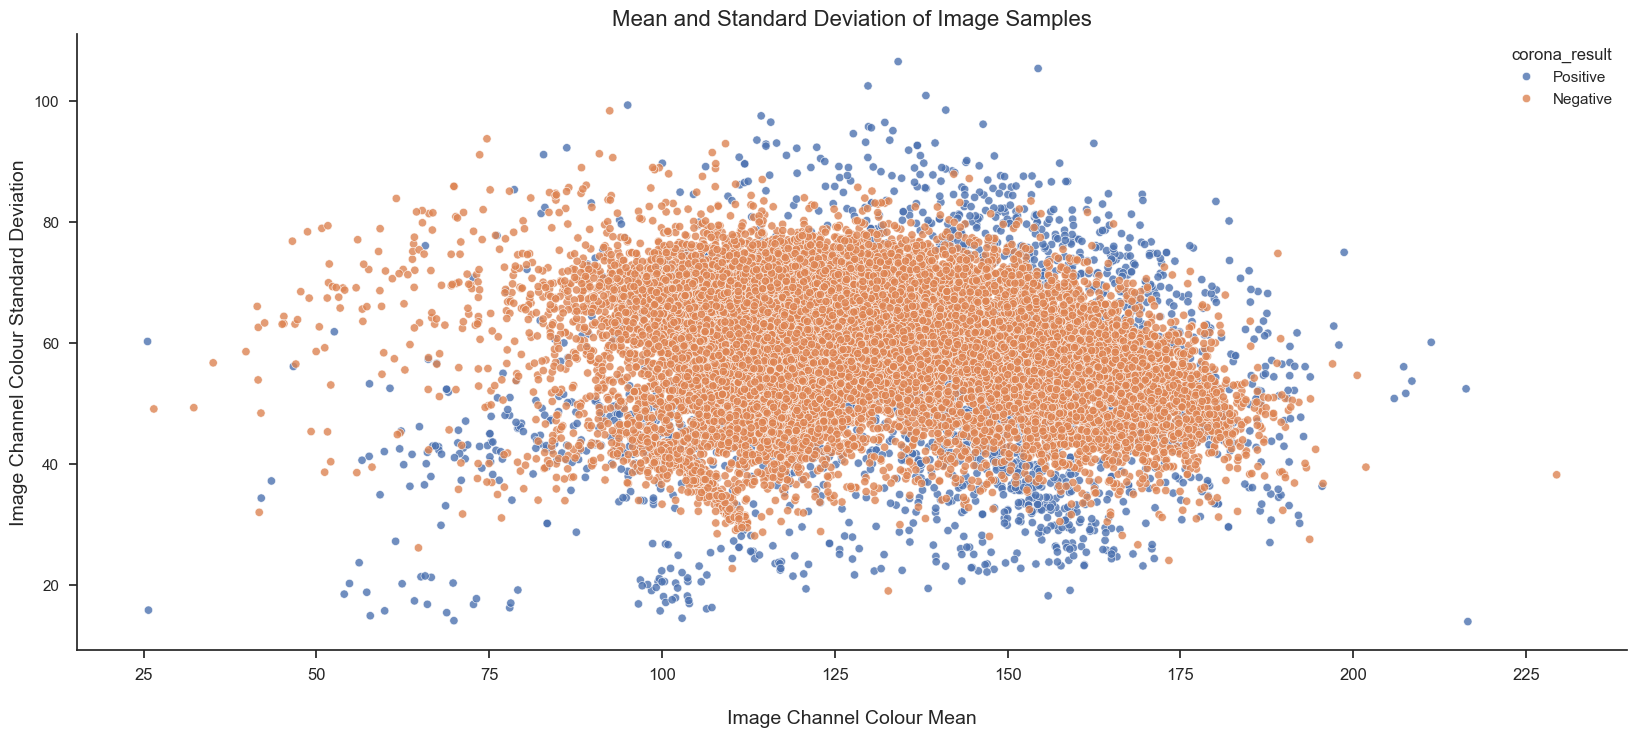

In [24]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

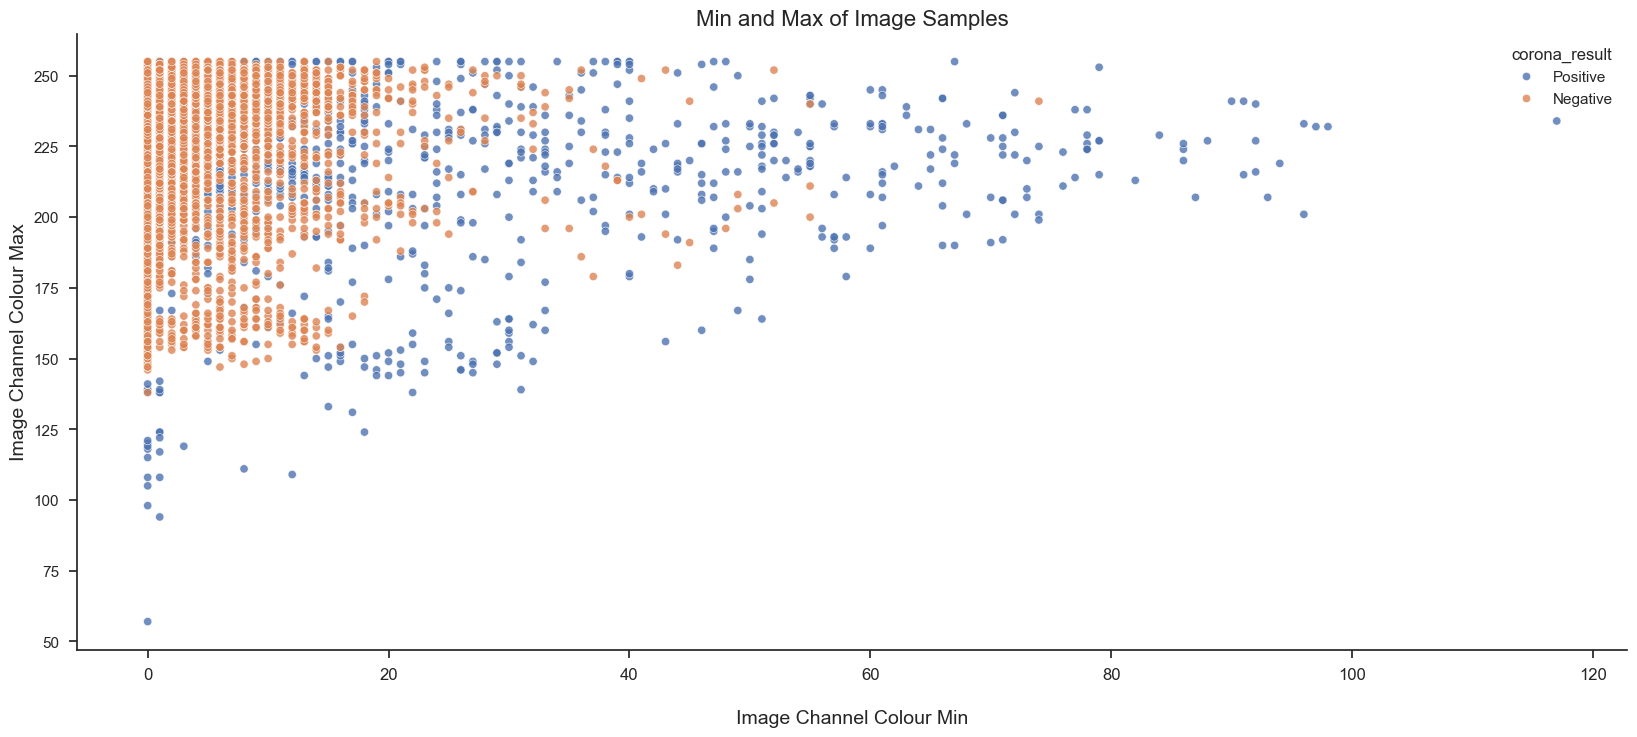

In [25]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "min", y = "max", hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Min', fontsize = 14)
ax.set_ylabel('Image Channel Colour Max', fontsize = 14)
plt.title('Min and Max of Image Samples', fontsize = 16);

<Figure size 1000x800 with 0 Axes>

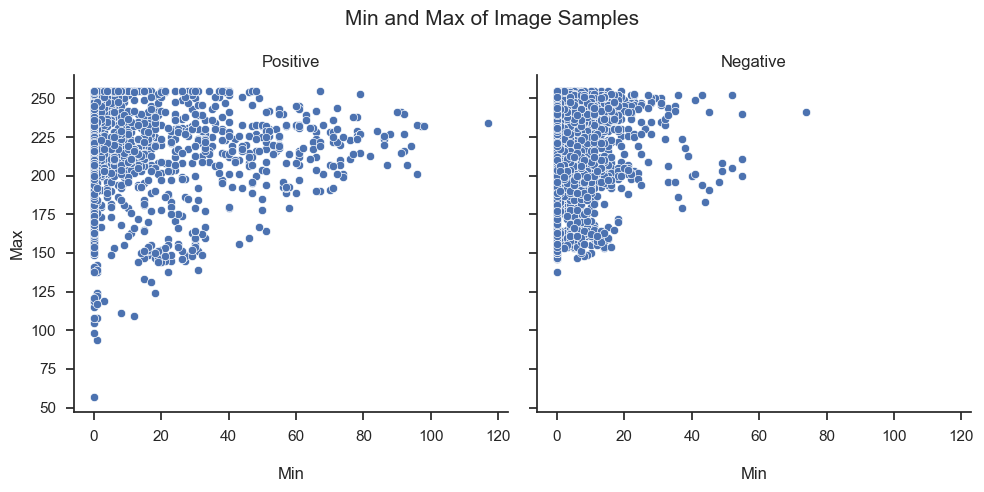

In [26]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'min', y = 'max');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Min and Max of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Max');
for ax in axes:
    ax.set_xlabel('\nMin');
g.fig.tight_layout();

Les points de données sont plus dispersés pour les patients Covid positifs, indiquant une plus grande variabilité dans les valeurs de pixels. Ainsi un patient avec une valeur minimale élevée et une valeur maximale faible peut être considéré comme positif. Ceci suggères que les radiographies des patients Covid positifs peuvent avoir des contrastes plus faibles et des zones opaques.

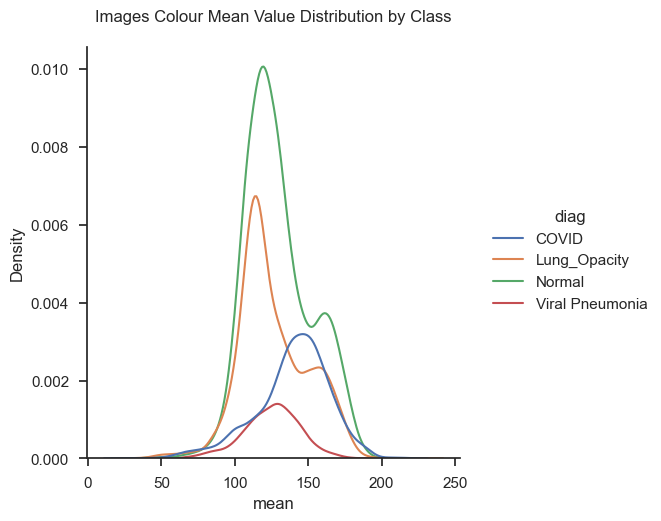

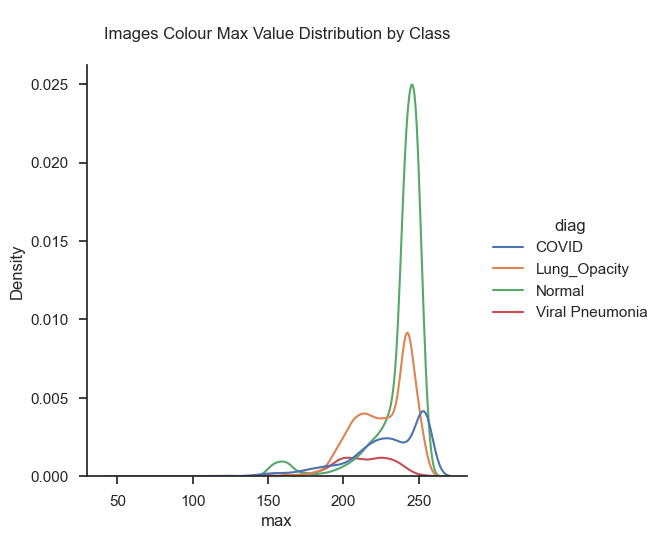

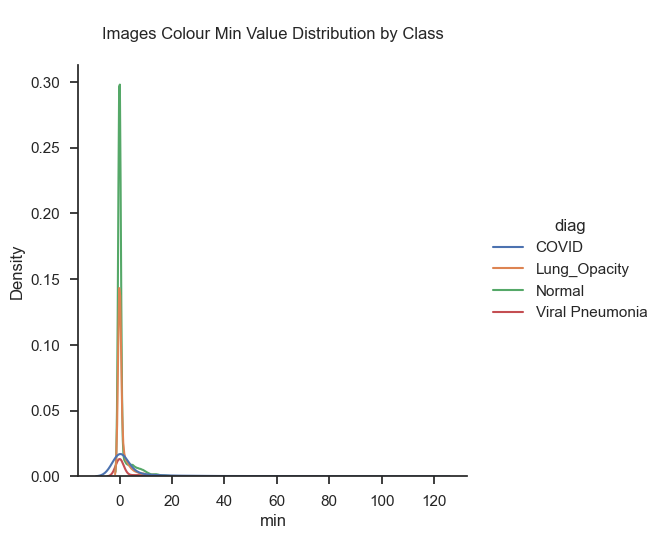

In [27]:
imageEDA2 = data.loc[:,['image','diag','path']]
imageEDA2['mean'] = mean_val
imageEDA2['stedev'] = std_dev_val
imageEDA2['max'] = max_val
imageEDA2['min'] = min_val

imageEDA2['subt_mean'] = imageEDA2['mean'].mean() - imageEDA2['mean']
imageEDA2['subt_std'] = imageEDA2['stedev'].mean() - imageEDA2['stedev']
imageEDA2['subt_max'] = imageEDA2['max'].mean() - imageEDA2['max']
imageEDA2['subt_min'] = imageEDA2['min'].mean() - imageEDA2['min']

ax1 = sns.displot(data = imageEDA2, x = 'mean', kind="kde", hue = 'diag');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA2, x = 'max', kind="kde", hue = 'diag');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA2, x = 'min', kind="kde", hue = 'diag');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

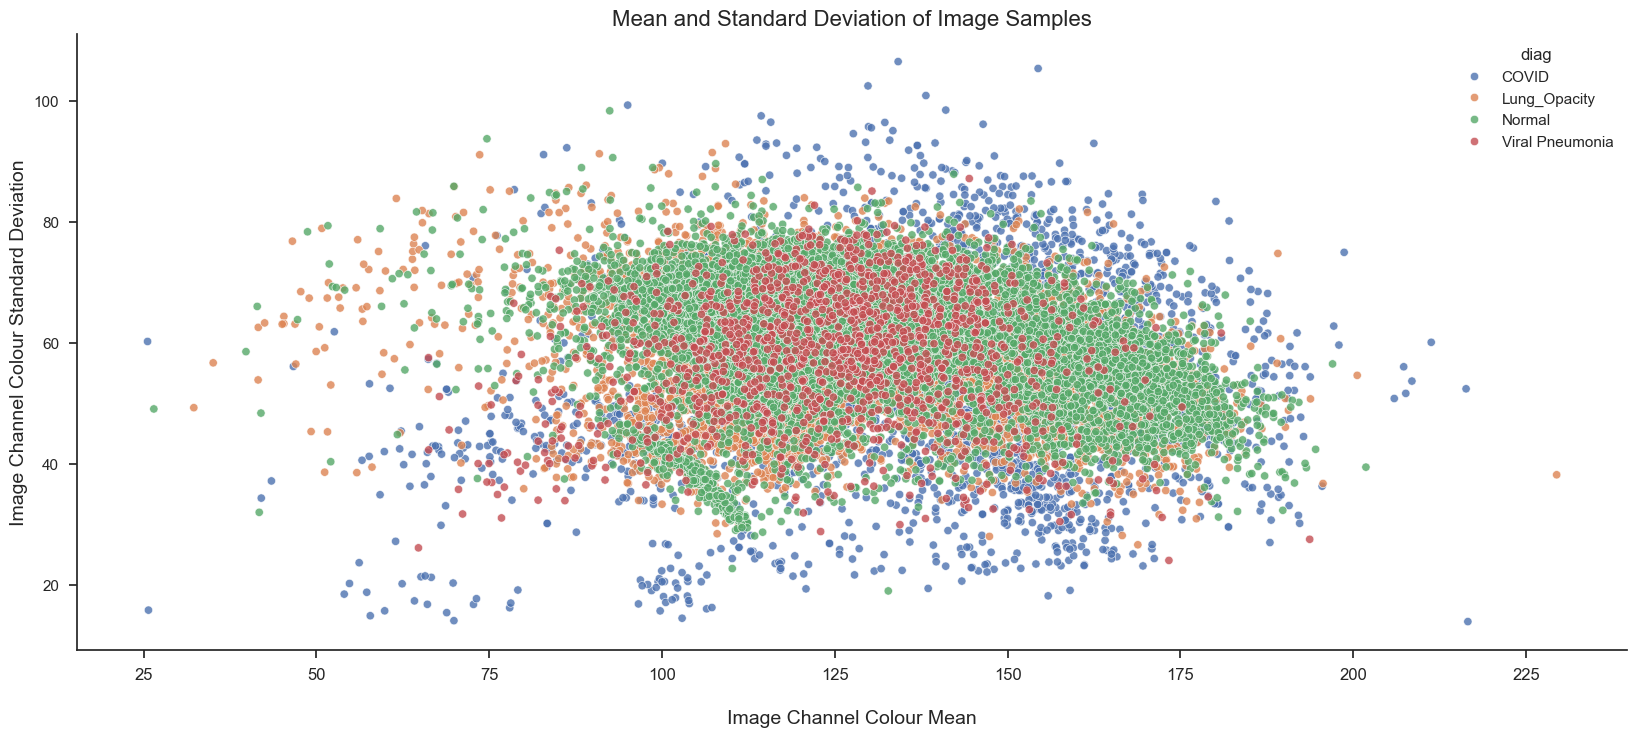

In [28]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA2, x = "mean", y = imageEDA2['stedev'], hue = 'diag', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

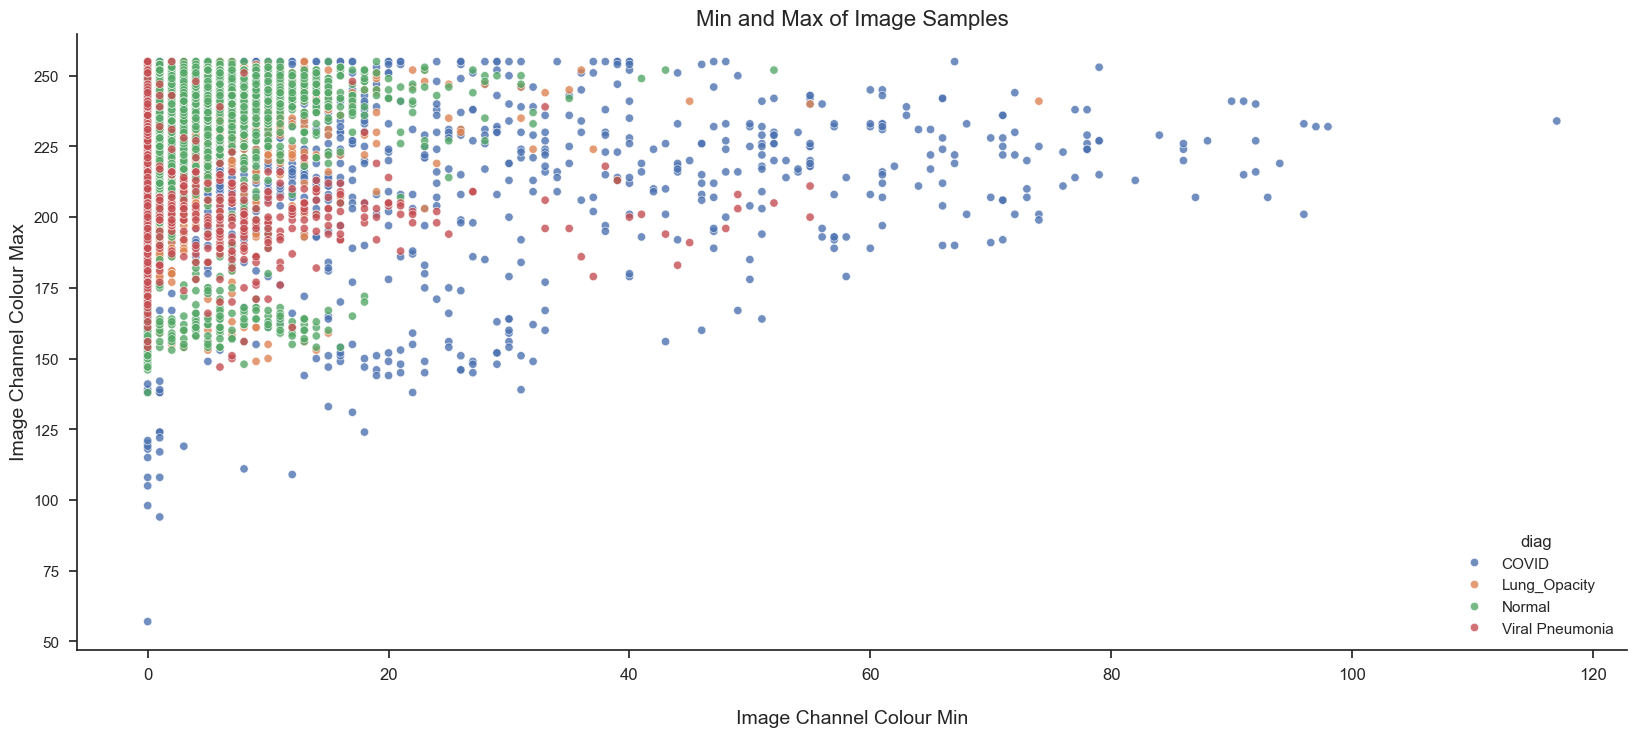

In [29]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA2, x = "min", y = "max", hue = 'diag', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Min', fontsize = 14)
ax.set_ylabel('Image Channel Colour Max', fontsize = 14)
plt.title('Min and Max of Image Samples', fontsize = 16);

<Figure size 1000x800 with 0 Axes>

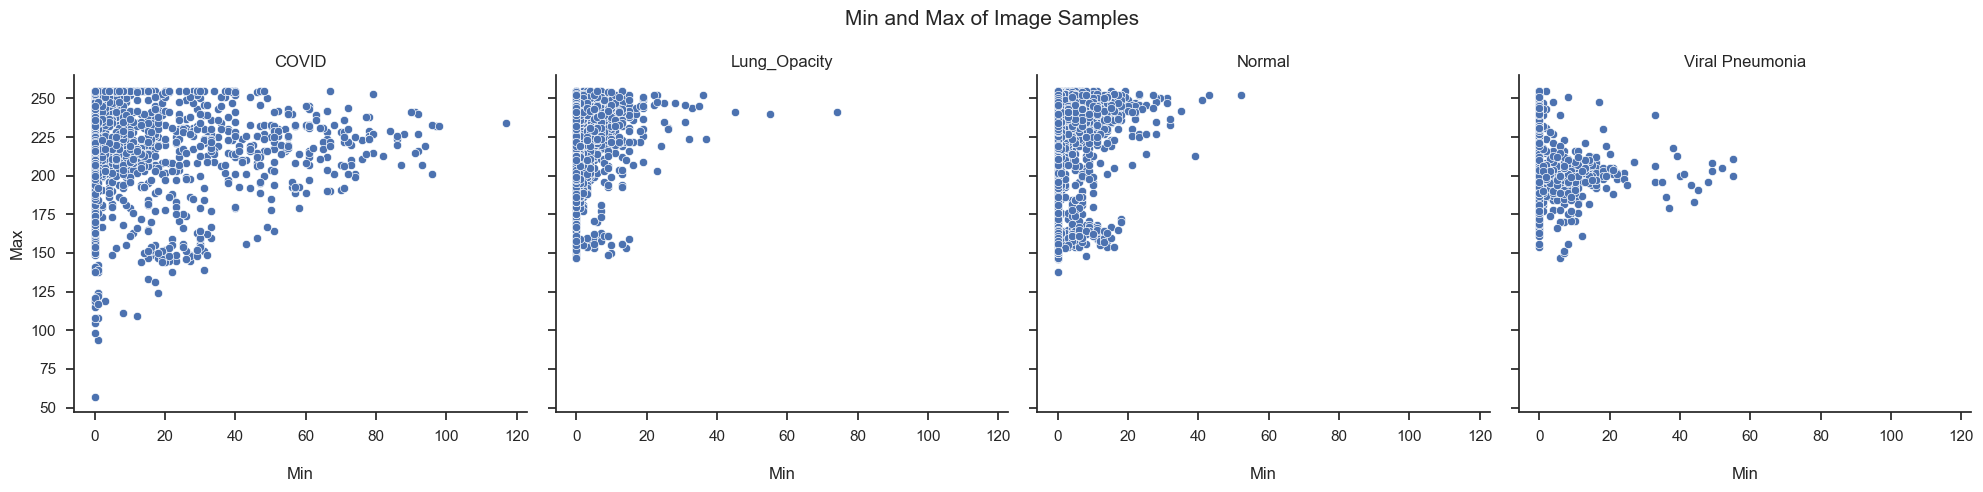

In [30]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA2, col = "diag", height = 5);
g.map_dataframe(sns.scatterplot, x = 'min', y = 'max');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Min and Max of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Max');
for ax in axes:
    ax.set_xlabel('\nMin');
g.fig.tight_layout();